## The Task for the AI

Our goal is to construct and train an artificial neural network on thousands of images of handwritten digits so that it may successfully identify others when presented. The data that will be incorporated is the MNIST database which contains 60,000 images for training and 10,000 test images. We will use the Keras Python API with TensorFlow as the backend.

<img src="https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/mnist.png?raw=1" >

## Prerequisite Python Modules

First, some software needs to be loaded into the Python environment.

In [ ]:
import numpy as np                   # advanced math library
import matplotlib.pyplot as plt      # MATLAB like plotting routines
import random                        # for generating random numbers

from keras.datasets import mnist     # MNIST dataset is included in Keras
from keras.models import Sequential  # Model type to be used

from keras.layers.core import Dense, Dropout, Activation # Types of layers to be used in our model
from keras.utils import np_utils                         # NumPy related tools

## Loading Training Data

The MNIST dataset is conveniently bundled within Keras, and we can easily analyze some of its features in Python.

In [ ]:
# The MNIST data is split between 60,000 28 x 28 pixel training images and 10,000 28 x 28 pixel images
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


Using matplotlib, we can plot some sample images from the training set directly into this Jupyter Notebook.

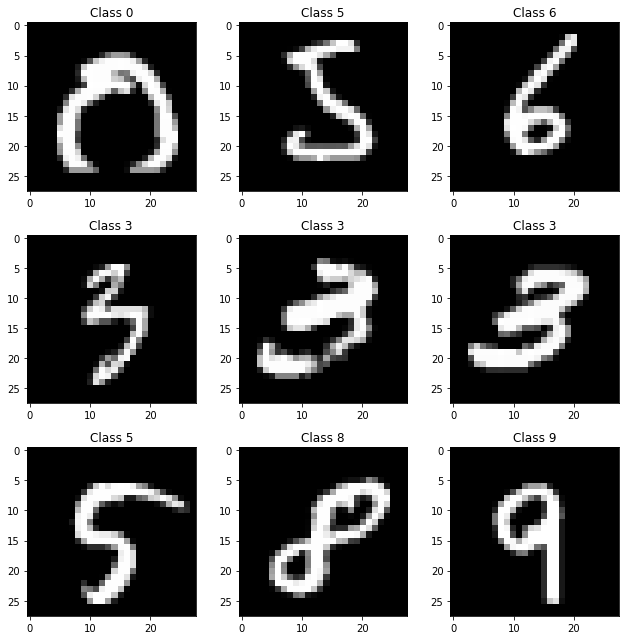

In [ ]:
plt.rcParams['figure.figsize'] = (9,9) # Make the figures a bit bigger

for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(X_train))
    plt.imshow(X_train[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[num]))
    
plt.tight_layout()

Let's examine a single digit a little closer, and print out the array representing the last digit.

In [ ]:
# just a little function for pretty printing a matrix
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

# now print!        
matprint(X_train[num])

0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0   0  0  0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0   0  0  0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0   0  0  0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0   0  0  0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0   0  0  0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0   0  0  0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0    0    0    0    0    0  115  159  159  179   37    0   0  0  0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0    0    0    7   73  193  253  254  254  254  237   54   0  0  0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0    0    0  195  254  254  202  122   67  206  254  208   9  0  0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0    6  16

Each pixel is an 8-bit integer from 0-255. 0 is full black, while 255 is full white. This what we call a single-channel pixel. It's called monochrome.

*Fun-fact! Your computer screen has three channels for each pixel: red, green, blue. Each of these channels also likely takes an 8-bit integer. 3 channels -- 24 bits total -- 16,777,216 possible colors!*

## Building a "Deep" Convolutional Neural Network

In [ ]:
# import some additional tools

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Flatten
from keras.layers.normalization import BatchNormalization

In [ ]:
# Load the MNIST data
(X_train,y_train),(X_test,y_test)= mnist.load_data()

In [ ]:
# Again, do some formatting
# Except we do not flatten each image into a 784-length vector because we want to perform convolutions first

#add an additional dimension to represent the single-channel
X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)

# change integers to 32-bit floating point numbers
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalize each value for each pixel for the entire vector for each input
X_train /= 255
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 28, 28, 1)
Testing matrix shape (10000, 28, 28, 1)


In [ ]:
# one-hot format classes for labels
number_of_classes = 10
Y_train = np_utils.to_categorical(y_train,number_of_classes, dtype='float32')
Y_test = np_utils.to_categorical(y_test,number_of_classes, dtype='float32')

We then modify our classes (unique digits) to be in the one-hot format, i.e.

```
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
etc.
```

If the final output of our network is very close to one of these classes, then it is most likely that class. For example, if the final output is:

```
[0, 0.94, 0, 0, 0, 0, 0.06, 0, 0]
```
then it is most probable that the image is that of the digit `1`.

In [ ]:
model = Sequential()                                 # Linear stacking of layers

# Convolution Layer 1
# 32 different 3x3 kernels -- so 32 feature maps
# normalize each feature map before activation
# activation

model.add(Conv2D(32,(3,3),input_shape=(28,28,1)))
model.add(BatchNormalization(axis=-1))
convLayer01 = Activation('relu')

model.add(convLayer01)

# Convolution Layer 2
# 32 different 3x3 kernels -- so 32 feature maps
# normalize each feature map before activation
# activation
# Pool the max values over a 2x2 kernel

model.add(Conv2D(32,(3,3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
convLayer02 = MaxPooling2D(pool_size=(2,2))


model.add(convLayer02)

# Convolution Layer 3
# 64 different 3x3 kernels -- so 64 feature maps
# normalize each feature map before activation
# activation
model.add(Conv2D(64,(3,3)))
model.add(BatchNormalization(axis=-1))
convLayer03 =Activation('relu')
model.add(convLayer03)

# Convolution Layer 4
# 64 different 3x3 kernels -- so 64 feature maps
# normalize each feature map before activation
# activation
# Pool the max values over a 2x2 kernel

model.add(Conv2D(64,(3,3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
convLayer04= MaxPooling2D(pool_size=(2,2))


model.add(convLayer04)

# Flatten final 4x4x64 output matrix into a 1024-length vector

model.add(Flatten())


# Fully Connected Layer 5
# 512 FCN nodes
# normalization
# activation
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))


# Fully Connected Layer 6                       
# 20% dropout of randomly selected nodes
# final 10 FCN nodes
# softmax activation

model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Activation('softmax'))

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_17 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
activation_19 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_18 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
activation_20 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 32)       

In [ ]:
# Compile the model Use adam for optimization 

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'], loss_weights=None, weighted_metrics=None, run_eagerly=None, steps_per_execution=None)

In [ ]:
# data augmentation prevents overfitting by slightly changing the data randomly
# Keras has a great built-in feature to do automatic augmentation

gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)

test_gen = ImageDataGenerator()

In [ ]:
# We can then feed our augmented data in batches
# This method actually results in significant memory savings
# because we are actually LOADING the data into the network in batches before processing each batch

# Before the data was all loaded into memory, but then processed in batches.

train_generator = gen.flow(X_train, Y_train, batch_size=128)
test_generator = test_gen.flow(X_test, Y_test, batch_size=128)

In [ ]:
# We can now train our model which is fed data by our batch loader
# Steps per epoch should always be total size of the set divided by the batch size

# SIGNIFICANT MEMORY SAVINGS (important for larger, deeper networks)

model.fit_generator(train_generator, steps_per_epoch=60000//128, epochs=5, verbose=1, 
                    validation_data=test_generator, validation_steps=10000//128)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
468/468 [==============================] - 180s 382ms/step - loss: 0.2942 - accuracy: 0.9060 - val_loss: 0.2837 - val_accuracy: 0.9100
Epoch 2/5
468/468 [==============================] - 180s 385ms/step - loss: 0.0507 - accuracy: 0.9839 - val_loss: 0.0932 - val_accuracy: 0.9681
Epoch 3/5
468/468 [==============================] - 180s 384ms/step - loss: 0.0401 - accuracy: 0.9875 - val_loss: 0.0270 - val_accuracy: 0.9922
Epoch 4/5
468/468 [==============================] - 181s 386ms/step - loss: 0.0343 - accuracy: 0.9891 - val_loss: 0.0585 - val_accuracy: 0.9813
Epoch 5/5
468/468 [==============================] - 181s 386ms/step - loss: 0.0272 - accuracy: 0.9913 - val_loss: 0.0430 - val_accuracy: 0.9870


In [ ]:
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 8s 26ms/step - loss: 0.0429 - accuracy: 0.9870
Test score: 0.0429474338889122
Test accuracy: 0.9869999885559082
